In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import PIL
from PIL import Image
import cv2

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

In [12]:
train_data_dir = "./01_data/train_data.bin"
val_data_dir = "./01_data/val_data.bin"
verification_code_dir = "./01_data/verification_code_data.bin"

def load_file(filename):
    with open(filename, 'rb') as f:
        result = pickle.load(f)
    return result

In [13]:
train_data = load_file(train_data_dir)
def show_img(train_data):
    img_test = list()
    for i in range(1, 1800, 50):
        img_test.append(train_data[i][1])
    plt.figure()
    for i in range(1, 37):
        plt.subplot(6, 6, i)
        plt.imshow(img_test[i-1])
        plt.xticks([])
        plt.yticks([])
    plt.show()


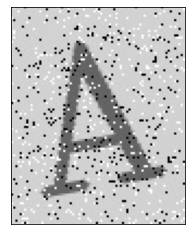

In [14]:
# 查看单张大图
plt.imshow(train_data[500][1])
plt.xticks([])
plt.yticks([])
plt.show()

In [15]:
# 1. 建立字符对照表
char_dict = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,
             'A':10,'B':11,'C':12,'D':13,'E':14,'F':15,'G':16,'H':17,'I':18,
             'J':19,'K':20,'L':21,'M':22,'N':23,'O':24,'P':25,'Q':26,'R':27,
             'S':28,'T':29,'U':30,'V':31,'W':32,'X':33,'Y':34,'Z':35}
new_char_dict = {v: k for k, v in char_dict.items()}

In [16]:
# 2. 定义datasets和dataloader
class MyDataset(Dataset):
    def __init__(self, filename, transforms):
        self.filename = filename
        self.image_label_arr = load_file(self.filename) # 读入二进制文件
        self.transforms = transforms    # 图片转换器

    def __getitem__(self, index):
        label, img = self.image_label_arr[index]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.medianBlur(img, ksize=3)
        img = self.transforms(img)
        return img, char_dict[label[0]]

    def __len__(self):
        return len(self.image_label_arr)

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize([28, 28]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=0.5)])

train_datasets = MyDataset(train_data_dir, transform)
train_loader = DataLoader(dataset=train_datasets, batch_size=32, shuffle=True)

val_datasets = MyDataset(val_data_dir, transform)
val_loader = DataLoader(dataset=val_datasets, batch_size=32, shuffle=True)

In [17]:
# 3. 定义网络结构
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3))
        self.fc1 = nn.Linear(in_features=2000, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=36)

    def forward(self, x):
        in_size = x.size(0)
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2)
        out = self.conv2(out)
        out = F.relu(out)
        out = out.view(in_size, -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = torch.log_softmax(out, dim=1)
        return out


In [18]:
# 4. 定义模型训练函数
def train(model: ConvNet, tran_loader: DataLoader, optimizer, epoch):
    model.train()
    for batch_idx , (data, target) in enumerate(tran_loader):
        # 1. 清空梯度
        optimizer.zero_grad()
        # 2. 前向传播
        output = model(data)
        # 3. 计算loss
        loss = F.nll_loss(output, target)
        # 4. 反向传播计算梯度
        loss.backward()
        # 5. 更新权重
        optimizer.step()

        if (batch_idx + 1) % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# 5. 定义模型测试函数
def test(model: ConvNet, test_loader: DataLoader):
    model.eval()
    test_loss = 0
    corrects = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum')
            pred = output.max(1, keepdim=True)[1]
            corrects += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader)
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) \n"
              .format(test_loss, corrects, len(test_loader),
                      100.* corrects / len(test_loader)))

Train Epoch: 1 [288/1800 (16%)]	Loss: 3.470932
Train Epoch: 1 [608/1800 (33%)]	Loss: 3.100797
Train Epoch: 1 [928/1800 (51%)]	Loss: 2.245708
Train Epoch: 1 [1248/1800 (68%)]	Loss: 1.200373
Train Epoch: 1 [1568/1800 (86%)]	Loss: 0.619617

Test set: Average loss: 12.6520, Accuracy: 314/12 (2617%) 

Train Epoch: 2 [288/1800 (16%)]	Loss: 0.321883
Train Epoch: 2 [608/1800 (33%)]	Loss: 0.132982
Train Epoch: 2 [928/1800 (51%)]	Loss: 0.107612
Train Epoch: 2 [1248/1800 (68%)]	Loss: 0.021704
Train Epoch: 2 [1568/1800 (86%)]	Loss: 0.019680

Test set: Average loss: 0.4150, Accuracy: 360/12 (3000%) 

Train Epoch: 3 [288/1800 (16%)]	Loss: 0.012050
Train Epoch: 3 [608/1800 (33%)]	Loss: 0.008997
Train Epoch: 3 [928/1800 (51%)]	Loss: 0.004256
Train Epoch: 3 [1248/1800 (68%)]	Loss: 0.005047
Train Epoch: 3 [1568/1800 (86%)]	Loss: 0.006767

Test set: Average loss: 0.1439, Accuracy: 360/12 (3000%) 



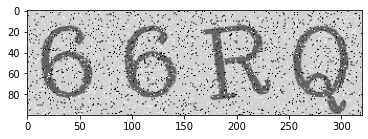

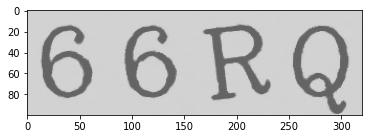

In [19]:
# 6. 定义模型和优化器
model = ConvNet()
optimizer = optim.Adam(model.parameters())

# 7. 模型训练与测试
EPOCHS = 3
for epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, epoch)
    test(model, val_loader)

# 8. 验证码识别
verification_code = load_file(verification_code_dir)

image = verification_code[6]
img = Image.fromarray(cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB))
plt.imshow(img)
plt.show()

# 添加滤镜
img = cv2.medianBlur(image.copy(), 5)
plt.imshow(img)
plt.show()


In [27]:
# 验证码是被结果
IMAGES = list()
NUMS = list()
def recognize_verification_code(verification_code_data):
    for img in verification_code_data:
        IMAGES.append(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        image_1 = img[:, :80]
        image_2 = img[:, 80:160]
        image_3 = img[:, 160:240]
        image_4 = img[:, 240:320]
        img_list = [image_1, image_2, image_3, image_4]

        nums = []
        for one_img in img_list:
            one_img = transform(one_img)
            one_img = one_img.unsqueeze(0)
            output = model(one_img)
            nums.append(new_char_dict[torch.argmax(output).item()])
        NUMS.append('Verification_code : '+''.join(nums))

    plt.figure(figsize=(20,20))
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1,11):
        plt.subplot(5,2,i)
        plt.title(NUMS[i-1],fontsize=25,color='red')
        plt.imshow(IMAGES[i-1])
        # plt.imshow(cv2.medianBlur(IMAGES[i-1], ksize=5))
        plt.xticks([])
        plt.yticks([])
    plt.show()

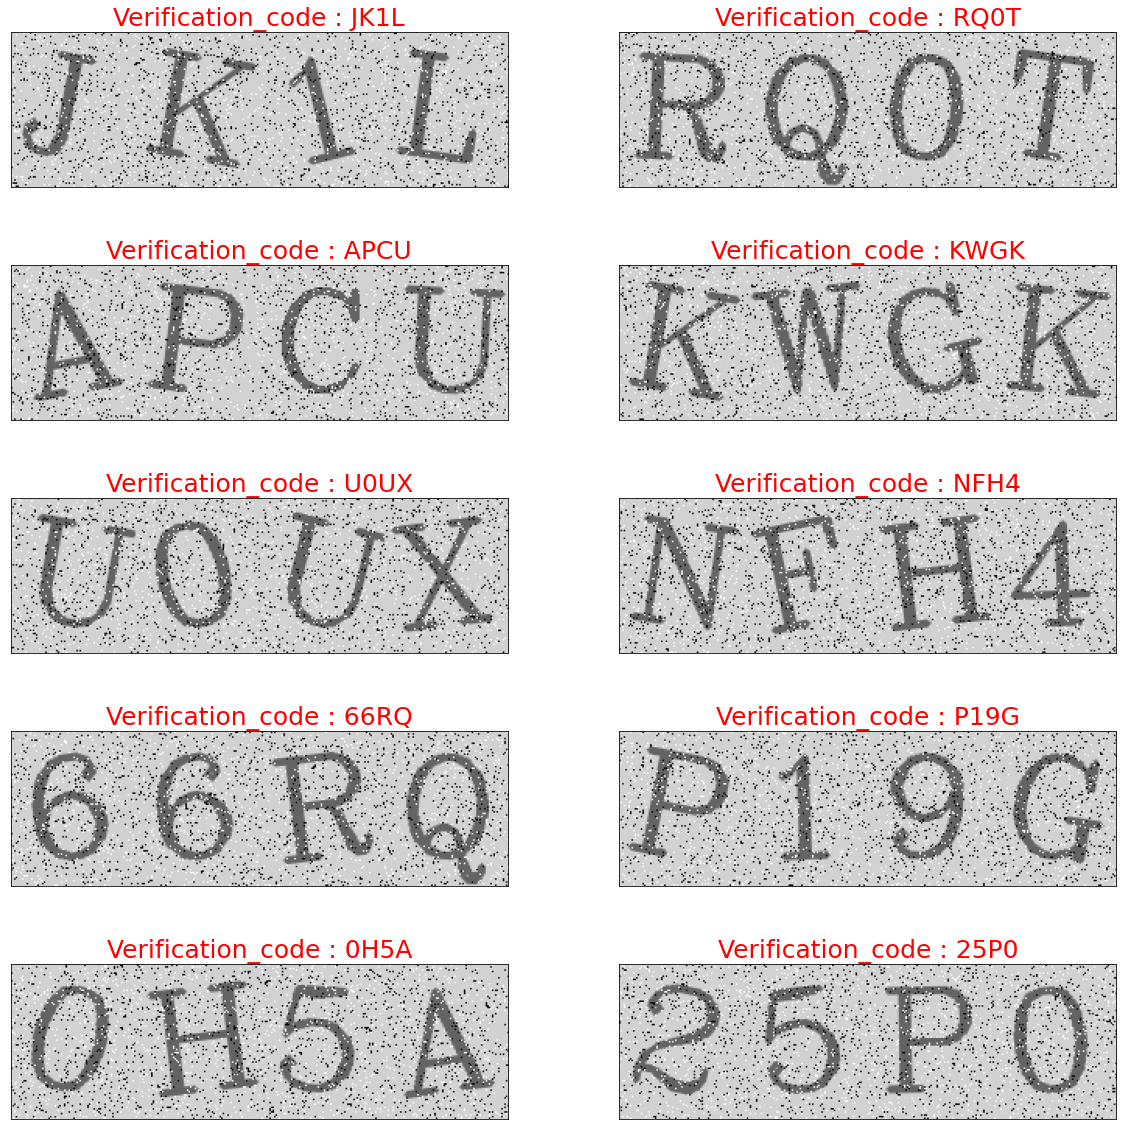

In [28]:
recognize_verification_code(verification_code)